## Pergunta 2 - KYBER

O objetivo é a criação de um protótipo para o algoritmo *KYBER*, 
seguindo o problema *RLWE* (*Ring Learning With Errors*), para
a criação de um esquema KEM/PKE.
É espectável que o algoritmo **KEM** seja **IND-CPA seguro**
e o algoritmo **PKE** seja **IND-CCA seguro**, para a técnica
pós-quântica (baseada em reticulados) **KYBER**.

A aplicação do *RLWE* em esquemas **PKE/KEM** é essencialmente baseada na abordagem de *Lyubashesvky*, *Peikert* e *Regev* (**LPR**) publicada em 2013.

O criptosistema *RLWE* é baseado no **LWE**, contudo:
- a_i, s e b_i são todos polinómios
- Envés do produto interno usa-se multiplicação polinomial (a_i * s = b_i gera tantas equações aproximadas quanto o grau dos b_i).

O algoritmo de RLWE é usado em esquemas criptográficos de reticulados, como o Kyber, para fornecer segurança contra ataques de computação quântica.

### Estratégia

Normalmente a construção de um esquema de cifra que seja **IND-CCA** seguro é algo mais complicado. 
No entanto existe um mecanismo, designado por transformação de *Fujisaki-Okamoto* (FOT), que permite (dentro de um contexto bastante lato) converter um esquema **PKE** com segurança **IND-CPA** num esquema **PKE** com segurança **IND-CCA**.

Sendo assim, o processo começará na definição de um esquema *PKE*, com 
base no algoritmo *KYBER*, que seja **IND-CPA seguro**.

Considerando a transformação de *Fujisaki-Okamoto*, transformar-se-à
esse num **PKE IND-CCA seguro**.

Para o **KEM**, utilizar-se o algoritmo anterior de *PKE*, *IND-CPA* seguro,
para o criar, sendo este, consequentemente, também *IND-CPA* seguro.

É de salientar que, no *paper* fornecido pela equipa docente,
são apenas dadas as étapas necessárias para implementar o *PKE IND-CPA* e
um *KEM IND-CCA* (o oposto do pedido no enunciado).

In [1]:
#imports
from cryptography.hazmat.primitives import hashes
import random
from pickle import dumps, loads

## NTT

O algoritmo *Number-Theoretic Transform* (NTT) é um algoritmo eficiente para computar a **Transformada de Fourier Discreta** (DFT) em corpos finitos, que são conjuntos finitos de números inteiros equipados com operações aritméticas adequadas. A *NTT* é frequentemente usada em algoritmos de criptografia, como o *KYBER*, que usa o problema de *RLWE*, como
mencionado anteriormente.

O algoritmo funciona por meio da divisão do polinômio em dois polinômios menores, calculando a transformada em cada um deles e combinando os resultados para obter a transformada do polinômio original. Esse processo é repetido recursivamente até que os polinômios sejam reduzidos a um único coeficiente, que é a transformada final do polinômio original.

A transformação é definida sobre um conjunto finito de raízes da unidade, que são usadas para expressar 
as expansões dos polinômios em termos de coeficientes nesses pontos. 
Estas raízes são escolhidas de modo a formar um grupo multiplicativo que possa ser usado para calcular 
a transformada e sua inversa de forma eficiente.

O algoritmo é descrito no **capítulo 2a**, dos *papers* fornecidos pela equipa docente, e reinforçado
no **capítulo 7** no âmbito do algoritmo *RLWE*,
seguindo-se essa estratégia de perto.

### Classe NTT

#### Método 'init'
A classe *NTT* é definida com **dois parâmetros opcionais**, **n** e **q**. 
O parâmetro *n* indica o tamanho do vetor que será transformado, 
que deve ser uma **potência de 2**, e *q* é o módulo que define o 
**corpo finito** sobre o qual a transformada será realizada.

Como especificado no *paper*:
- O primeiro passo é a escolha de um N da forma 2^d e um primo q que verifique q ≡ 1 mod 2N.

De seguida, define-se **o anel (*Galois*) dos inteiros módulo q, que é usado para realizar a aritmética modular**,
na forma do valor *F*.

Este é usado para criar o corpo finito, que será utilizado nas operações matemáticas da implementação do algoritmo,
o valor *R*.
*R* é um anel de polinômios, ou seja, é o anel formado por polinômios com coeficientes no anel *F*;
e o gerador do anel é denotado por *w*, para seguir o algoritmo definido no *paper*
(usada para construir polinómios em *R*).

São trabalhados na transformada polinómios do tipo *w^n+1*, tal como definido na var *g*.
É encontrado o último zero do polinômio *g,* que é a raiz primitiva *xi*
que será usada na transformada.

Em seguida, é definido um conjunto de *n* raízes da unidade *rs*, 
que são as potências de *xi* com **expoente ímpar**. 
Essas raízes são usadas para definir a base **CRT** (*Chinese Remainder Theorem*)
que será usada na inversa da transformada.

Mais uma vez, é reiterado que o algoritmo de inicialização (a parametrização),
segue próximo os passos do **capítulo 2a/7**, dos *papers*.

#### Método 'ntt'

Para o algoritmo *NTT*, dividiu-se o trabalho em dois
métodos auxiliares adicionais:
1. ntt_alg;
2. expand.

Começando pelo mais simples, o *expand*.
O método *expand(f)* serve para **expandir o polinômio f com zero coeficientes à direita**, 
tornando o seu comprimento igual a *n*. 
O passo é necessário para que a transformada seja aplicada corretamente a *f*, 
já que é esperado um polinômio de comprimento *n*.

A expansão é realizada pelo método *list()*, que retorna a lista de coeficientes do polinômio *f*, 
e a adição de zeros à direita é feita com o comando **return u + [0]*(self.n-len(u))**.

Por exemplo, se *f = x^3 + x^2 + 2x + 1 e n=8*, então *expand(f)* retorna [1, 2, 1, 1, 0, 0, 0, 0].

O segundo, *ntt_alg*, recebe como *input*:
- a raiz primitiva xi do corpo finito;
- o tamanho N do vetor;
- vetor f de coeficientes do polinômio a ser transformado.

É feita a divisão do vetor em dois e chama, recursivamente, o próprio método *ntt*
para cada metade. 
Após essa divisão, ele multiplica cada valor correspondente do 
vetor resultante da chamada recursiva pela potência correspondente de *xi* e soma 
as duas parcelas para produzir os dois valores correspondentes do vetor resultante.
Esse processo é repetido para todas as potências de *xi* até que todos os valores do 
vetor resultante tenham sido calculados.

Deste modo, o método *ntt_alg* segue o algoritmo:
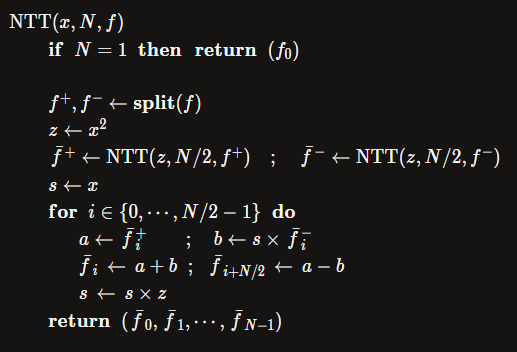

Com estas duas, o método **ntt** é calculado,
usando o método *ntt_alg*, com o polinómio
expandido no seu *input*.


#### Método 'ntt_inv'

No âmbito da **transformada NTT inversa**, seguiu-se 
o algoritmo nos mesmo capítulos; sendo esta 
a **abordagem 1**.

Neste caso, segue-se:

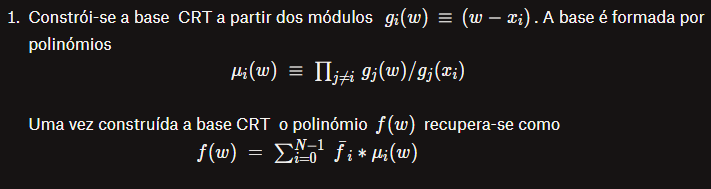

In [2]:
class NTT:

    def __init__(self, n, q):
        
        # Se n for escolhido arbitrariamente
        if n not in [32,64,128,256,512,1024,2048]:
            raise ValueError("O tamanho do vetor escolhido não é uma potência de 2 válida!",n)
            
        self.n = n
        
        # Caso q não seja fornecido pelo utilizador
        if not q:
            
            # o valor de q, por definição, deve ser q = 1 mod 2n
            self.q = 1 + 2*n
            
            while True:
                
                # Verifica-se se q é um valor primo (obrigatório)
                if (self.q).is_prime():
                    break    
                self.q += 2*n
        else:
            # Verifica-se se o q fornecido pelo utilizador é válido
            if q % (2*n) != 1:
                raise ValueError("O q não se enquadra no valor obrigatório, segundo a transformada NTT!")
                
            self.q = q
        
        # anel infinito (para construir R)
        self.F = GF(self.q) 
        
        # anel de polinómios
        self.R = PolynomialRing(self.F, name="w")
        
        # Gerador do anel polinomial R
        w = (self.R).gen()
        
        # Temos que phi (variável xi) é um polinómio do tipo w^N + 1
        g = (w^n + 1)
        
        xi = g.roots(multiplicities=False)[-1]
        
        self.xi = xi
        
        # Para o cálculo da inversa
        rs = [xi^(2*i+1)  for i in range(n)] 
        self.base = crt_basis([(w - r) for r in rs]) 
        
    ## ---------------------------- Métodos principais ----------------------------
    
    # Método para calcular a transformada NTT
    def ntt(self,f):
        return self.aux_ntt(self.xi,self.n, self.poli_expand(f))
        
    # Método para calcular a inversa da transformada NTT
    def ntt_inv(self,ff):                             
        return sum([ff[i]*self.base[i] for i in range(self.n)])
    
    ## ---------------------------- Métodos auxiliares ----------------------------
    
    # Método auxiliar com o algoritmo NTT
    def aux_ntt(self, xi,N,f):
        if N==1:
            return f
        N_ = N/2 ; xi2 =  xi^2  
        f0 = [f[2*i]   for i in range(N_)] ; f1 = [f[2*i+1] for i in range(N_)] 
        ff0 = self.aux_ntt(xi2,N_,f0) ; ff1 = self.aux_ntt(xi2,N_,f1)  

        s  = xi ; ff = [self.F(0) for i in range(N)] 
        for i in range(N_):
            a = ff0[i] ; b = s*ff1[i]  
            ff[i] = a + b ; ff[i + N_] = a - b 
            s = s * xi2                     
        return ff
    
    # Método para expandir o polinómio (no lado direito)
    def poli_expand(self,f): 
        u = f.list()
        return u + [0]*(self.n-len(u))     

### KYBER-CPAPKE

Como mencionado na introdução, o processo começa com a criação de
um **PKE IND-CPA**, segundo o algoritmo/técnica *KYBER*; neste caso, 
vai-se seguir o *paper* fornecido pela equipa docente,
o *CRYSTALS_KYBER - Algorithm Specifications And Supporting Documentation (version 3.0)*.

Este descreve, entre outros, os métodos para poder **gerar um par de chaves**, **cifrar uma mensagem** e
a respetiva **decifragem** (para um *PKE IND-CPA* seguro).

*IND-CPA* significa "**indistinguível sob ataque de texto cifrado escolhido**".
Um esquema criptográfico é considerado *IND-CPA* seguro se um atacante não 
conseguir distinguir entre o texto cifrado de uma mensagem escolhida por ele 
e o texto cifrado de uma mensagem aleatória escolhida pelo algoritmo de cifragem, 
mesmo tendo acesso ao texto cifrado de ambas as mensagens. 
Em outras palavras, o atacante não pode aprender informações sobre a mensagem
original a partir do texto cifrado escolhido.

Adicionalmente, dado a ser a primeira opção (a mais pequena), 
escolheu-se implementar o *KYBER* **512**;
pelo que o tamanho do módulo do **reticulado** a usar no processo será 512.
Quanto maior o tamanho, maior será a segurança; contudo, num contexto
académico, tal não será necessário para o protótipo.

Como prefácio para a explicação a seguir, para cada um dos métodos:
- *keyGen* - **geração das chaves**;
- *enc* - **Cifragem da mensagem**;
- *dec* - **Decifragem da mensagem**;

... utilizou-se os algoritmos **4**, **5** e **6** do *paper*,
relativos ao *KYBER.CPAPKE*.

#### Método 'init'

Seguindo o *paper*, alguns parâmetros são apresentados como necessários,
antes de se efetuar as ações:
- **n** Tamanho do polinómio (**256** por *default*)
- **k** Tamanho das matrizes a serem criadas (kxk)
- **q** Módulo do polinómio (**7681** por *default*)
- **n1**|**n2** Parâmetros para gerar uma matriz densa (*noise*)
- **du** Diferença finita para a frente
- **dv** Diferença finita para trás
- **M** Matriz para a transformada NTT 

Tem-se que *n* é escolhido com valor 256 uma vez que se 
pretende **encapsular chaves com 256 bits de entropia**;
valores mais pequenos iriam requerer que fosse realizado
um *encoding* de mútiplos *bits* da chave num único coeficiente 
polinomial (menos security).
Valores maiores reduziriam a capacidade de escalar a segurança
com o parâmetro *k*.

*q* é uma valor primo "pequeno" para permitir
uma multiplicação mais rápida com base na transformada *NTT*.

O *k* é selecionado para fixar a dimensão da rede(*lattice*) 
como um múltiplo de *n*.

Os restantes parâmetros (n1, n2, du e dv) foram escolhidos 
para balançar a segurança (maioritariamente usados para *noise*
no algoritmo).

Não obstante, todos os valores escolhidos foram retirados
diretamente do *paper* (para o *KYBER* 512), uma vez que estão testados
e documentados, como se visualiza em:

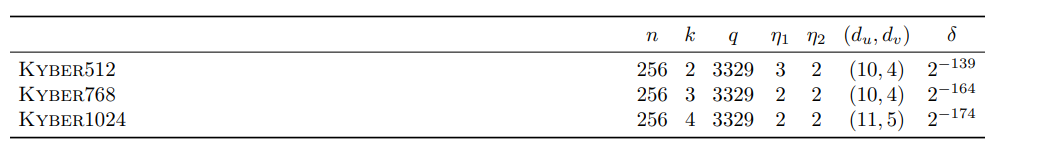

#### Funções auxiliares

Seguindo o **algoritmo 4** do *paper*, tem-se que serão necessárias,
para os 3 algoritmos especificados, algumas funções auxiliares:
- **BytesToBits** Percorre cada elemento do *array* de *bytes*, converte cada num vetor de *bits* de *8* dígitos (1 *byte*) usando operações de divisão e módulo. Adiciona cada *bit* do vetor de *bits* ao *bitarray* final.
- **G** Operação de *hashing* usando o algoritmo **SHA3-512**. (para cálculo de ρ, σ).
- **XOF** Função para criar um *extendable ouput*.
- **PRF** Função para criar um *output* pseudo-aleatório.
- **Parse** O *KYBER* utiliza uma estratégia determinística para dar *sample* dos elementos em *Rq* (que são estatisticamente próximos de uma distribuição normal). Para este *sampling*, criou-se a função *parse*:
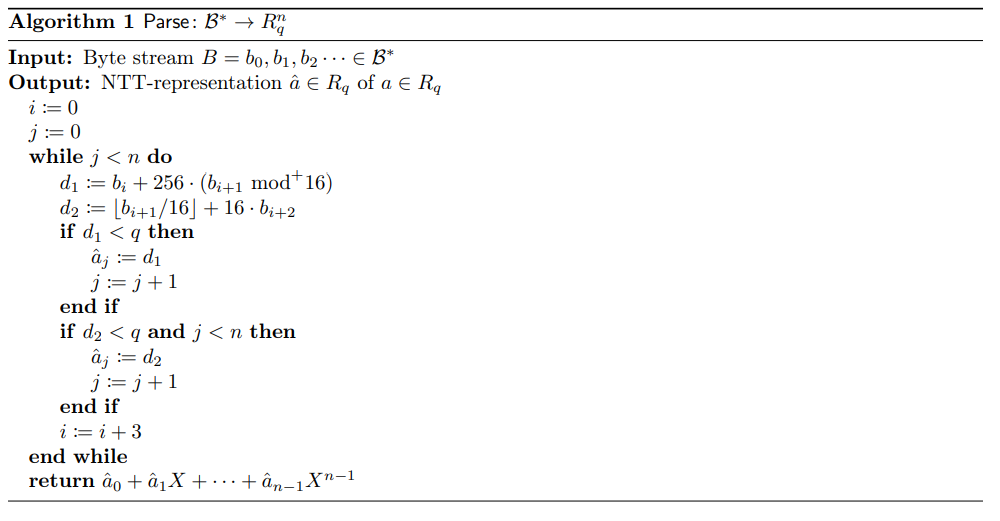

- **CBD** Para a especificação do *KYBER* é necessário definir como um polinómio f ∈ Rq é *sampled* relativamenmte à distribuição binomial *B*. Para tal criou-se o método *CBD* (*Center binomial distribuition*):
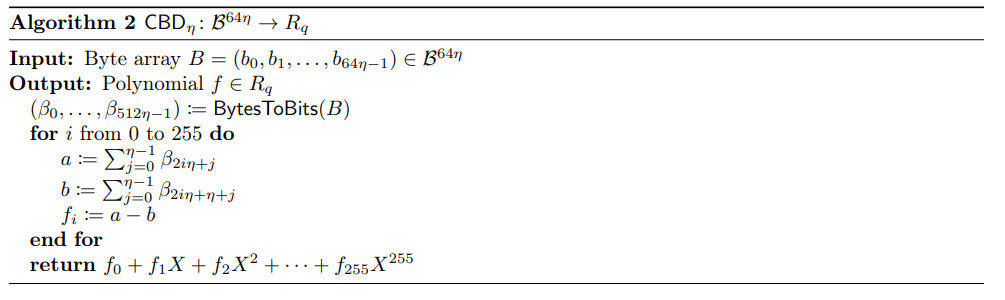

- **Decode** Existem dois tipos de dados que o *KYBER* precisa de serializar para *byte arrays*: *byte arrays* e polinómios. A função *decode* tem como objetivo a desserialização de polinómio (para *byte arrays*), como se visualiza em:
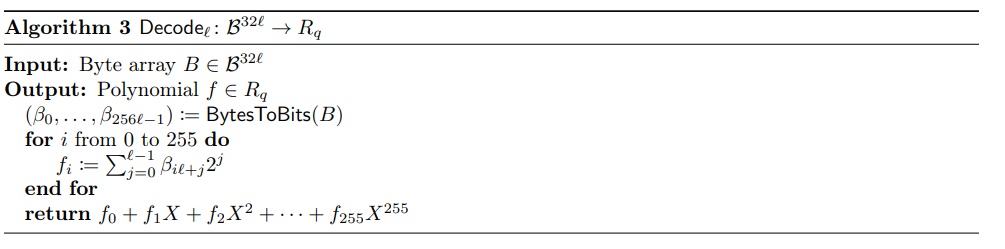

- **Compress** and **Decompress** Os métodos *Compress* e *Decompress*, como especificados no documento, são usados no âmbito de remover alguns *low-order bits* no criptograma, que não têm muito efeito na correção da decifragem (e reduz o tamanho do criptograma). Também são usados para realizar correção de erros *LWE* na cifragem/decifragem. 

Como nota adicional, as funções de *hashing* usadas nos
métodos **G**, **XOF** e **PRF** encontram-se todas 
detalhadas no documento do *KYBER*, mencionado
anteriormente.
As funções são, respetivamente, *SHA-512*, *SHAKE-128*
e *SHAKE-256*.

Adicionalmente, como estão ser efetuadas operações com matrizes,
criou-se um conjunto de **métodos auxiliares** para executar 
essas ações; nomeadamente, soma, subtração e multiplicação de 
matrizes/vetores.

#### Método 'keyGen'

O método *KeyGen* tem como objetivo gerar uma chave **pública** 
e outra **privada** para serem utilizadas no processo 
de cifragem/decifragem (*Enc* e *Dec*).
Este foi implementando seguindo o **algoritmo 4**, como 
anteriormente referido.
O algoritmo:
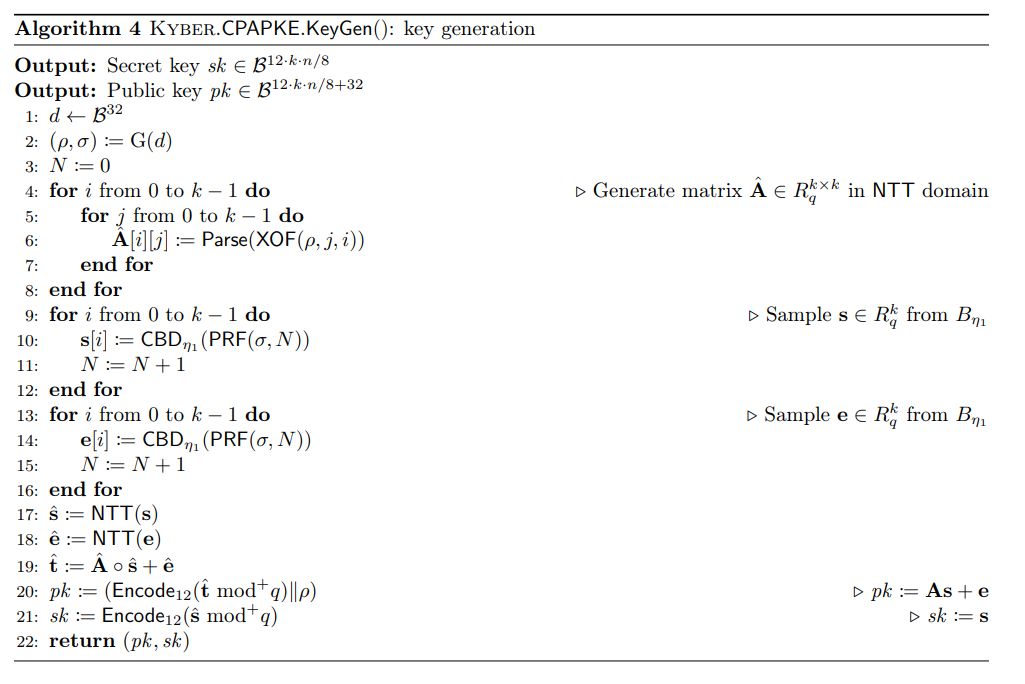

- Determina a matriz A ∈ Rq, no domínio *NTT*;
- Determina as *samples* (vetores) *s* e *e* ∈ Rq. (com recursos aos métodos auxiliares *Parse*, *XOF*, *CBD* e *PRF*);
- Retorna a chave pública *pk* e a privada *sk*, num tuplo.

#### Método 'Enc'

O método *Enc* tem como objetivo **cifrar** uma mensagem.
Para tal recebe a mensagem, *m*, a chave pública, *pk* e
um valor *r*, as *coins*, que é um valor gerado aleatoriamente.
A partir disto, vai-se conseguir gerar um criptograma da
mensagem *m* (com base no anel *Rq*).
Seguiu-se o **algoritmo 5**, que se visualiza:
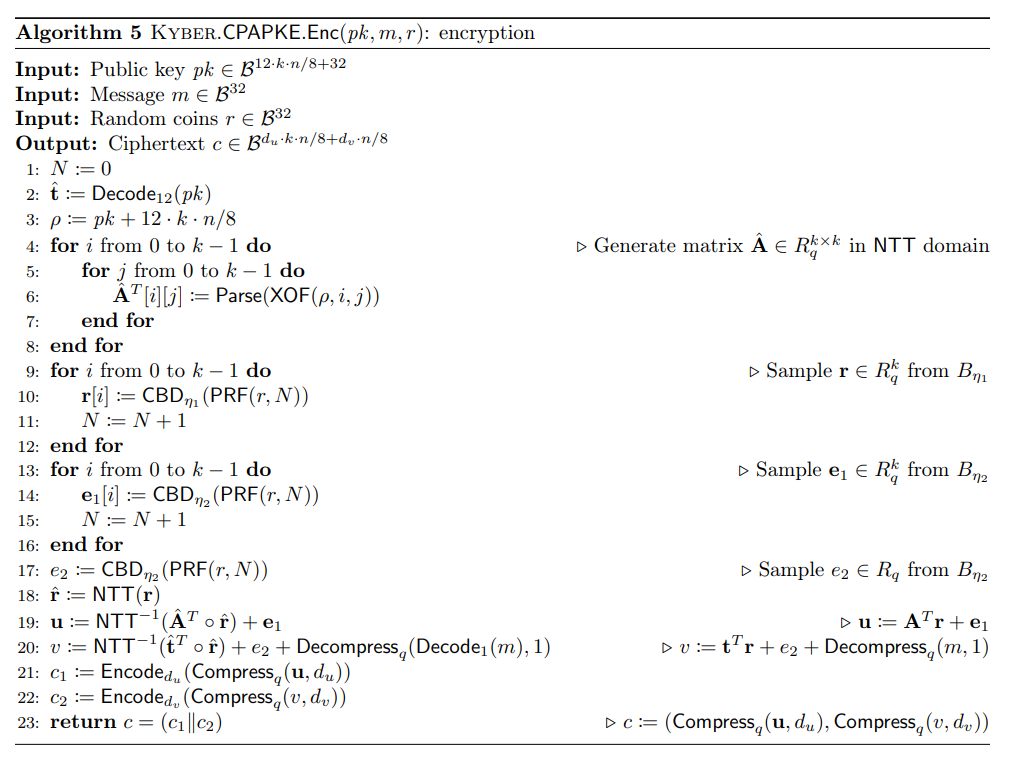

- Determina a matriz A ∈ *Rq*, no domínio *NTT*;
- Determina os vetores r, e1, e2 ∈ *Rq*;
- Determina-se u, com recurso ao método *Compress* e aos vetores r e e1 - *u = A^T * r + e1*.
- Determina-se v, com a adição do método *Decompress* e os vetores r e e2 - *v = t^T * r + e2 + Decompress(m, 1).*
- Cria-se o criptograma *c*, da seguinte forma, c = (*Compress(u, du),Compress(v,dv)*).

#### Método 'Dec'

O método *Dec* tem como objetivo **decifrar** uma mensagem.
Recebe, para tal, o **criptograma** *c* e a **chave pública** *sk*.
Neste caso, o resultado final deverá ser a mensagem original *m*,
antes de ter sido cifrada, a partir do método *Enc*.

O **algoritmo 6**, para a **decifragem**:
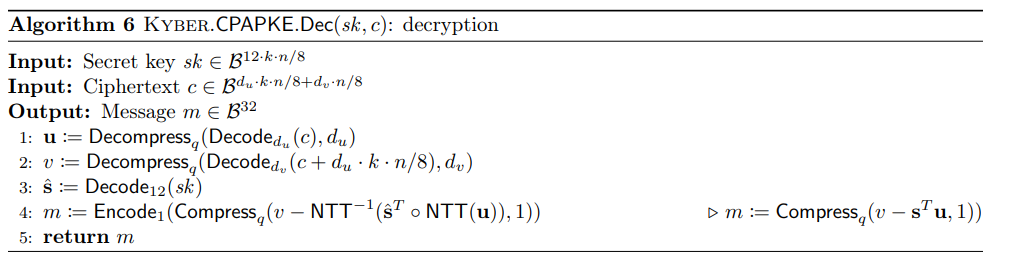

- Determinar os vetores *u* e *v* (utilizando o método *Decompress*);
- Com o *decoding* da chave privada feito, obtém-se a mensagem através da expressão: *Compress(v - s^T *u , 1)*.

In [3]:
class KYBER_CPAPKE:
    
    ## --------------------------------- Inicialização --------------------------------- ##
    
    def __init__(self):
        
        self.n = 256
        self.q = 7681
        self.k = 2
        self.n1 = 3
        self.n2 = 2
        self.du = 10
        self.dv = 4
        
        Z.<w> = GF(self.q)[]
        
        # Polinónimo irredutível f
        f = w^self.n + 1
        
        # Anel quociente de polinómios inteiros
        Rq.<w> = QuotientRing(Z ,Z.ideal(f))
        self.Rq = Rq
        
        # Matriz da transformada NTT
        self.M = NTT(self.n,self.q)

    ## --------------------------------- Funções Principais --------------------------------- ##
    
    # Gerador de chaves privada/pública (a usar no processo de cifra/decifrar)
    def KeyGen(self):
        
        # d ← B32
        d = bytearray(os.urandom(32))
        
        # (ρ, σ) := G(d)
        ro,sigma = self.G(d)
        
        # N := 0
        N = 0
        
        # Generate matrix Â ∈ Rq(k x k) in NTT domain
        mat_a = []
        
        # Temos que são matrizes (k x k)
        for i in range(self.k):
            mat_a.append([])
            for j in range(self.k):
                mat_a[i].append(self.M.ntt(self.Parse(self.XOF(ro,j,i))))
        
        
        # Sample s ∈ Rq from Bη1
        sample_s = []
                
        for i in range(self.k):
            sample_s.insert(i,self.CBD(self.PRF(sigma, N), self.n1))
            N = N+1
            
        # Sample e ∈ Rq from Bη1
        sample_e = []
            
        for i in range(self.k):
            sample_e.insert(i,self.CBD(self.PRF(sigma, N), self.n1))
            N = N+1

        # ŝ := NTT(s), ê := NTT(e)
        for i in range(self.k) :
            sample_s[i] = self.M.ntt(sample_s[i])
            sample_e[i] = self.M.ntt(sample_e[i])
            
        # t1 := Â ◦ ŝ
        t1 = m_matrix_vec(mat_a, sample_s, self.k, self.n)
        # t := t1 + ê
        t = sum_matrix(t1, sample_e, self.n)
        
        # pk := As + e
        pk = t, ro
        # sk := s
        sk = sample_s
        
        return pk,sk
    
    
    # Cifrar uma mensagem m, através da chave pública pk e um valor aleatório r
    def Enc(self,pk ,m ,r):
        
        # N := 0
        N = 0
        
        t, ro = pk
        
        # Generate matrix Â ∈ Rq in NTT domain
        mat_a = []
    
        for i in range(self.k):
            mat_a.append([])
            for j in range(self.k):
                mat_a[i].append(self.M.ntt(self.Parse(self.XOF(ro,i,j))))
        
        # Sample r ∈ Rq from Bη1, ^r:= NTT(r)
        sample_r = []
    
        for i in range(self.k):
            sample_r.insert(i,self.M.ntt(self.CBD(self.PRF(r, N), self.n1)))
            N += 1
        
        # Sample e1 ∈ Rq from Bη2
        sample_e1 = []
    
        for i in range(self.k):
            sample_e1.insert(i,self.CBD(self.PRF(r, N), self.n2))
            N += 1
        
        # Sample e2 ∈ Rq from Bη2
        sample_e2 = self.CBD(self.PRF(r, N), self.n2)
        
        # Â ◦ r̂
        u1 = m_matrix_vec(mat_a, sample_r, self.k, self.n)
        
        # NTT-1( Â ◦ r̂)
        u2 = []
        for i in range(len(u1)) :
            u2.append(self.M.ntt_inv(u1[i]))
        
        # u := NTT( Â ◦ r̂) + e1
        u3 = sum_matrix(u2, sample_e1, self.n)
        
        u = []
        for i in range(len(u3)) :
            u.append(self.Rq(u3[i]))
            
        # t̂ ◦ r̂
        v1 = mult_matrix(t, sample_r,self.n)
        
        # NTT-1( t̂ ◦ r̂)
        v2 = self.M.ntt_inv(v1)
        # NTT-1( t̂ ◦ r̂) + e2
        v3 = self.Rq(sum_vecs(v2, sample_e2, self.n))
        
        # Decompress(m, 1)
        m_decom = self.Decompress(m, 1)
        # v := NTT-1( t̂ ◦ r̂) + e2 + Decompress(m, 1)
        v = self.Rq(sum_vecs(v3, m_decom, self.n))
        
        # Compress(u, du)
        c1 = []
        
        for i in range(len(u)):
            c1.append(self.Compress(u[i],self.du))
        
        
        # Compress(v, dv)
        c2 = self.Compress(v,self.dv)
        
        return (c1,c2)
    
    
    def Dec(self,sk, c):
        
        c1, c2 = c
        
        # Decompress(c1,du)
        u = []
        
        for i in range(len(c1)):
            u.append(self.Decompress(c1[i],self.du))
        
        # Decompress(c2,dv)
        v = self.Decompress(c2,self.dv)

        # NTT(u)
        ntt_u = []
        for i in range(len(u)) :
            ntt_u.append(self.M.ntt(u[i]))
        
        # ŝ ◦ NTT(u)
        m1 = mult_matrix(sk, ntt_u, self.n)
        
        # v - NTT-1(ŝ ◦ NTT(u))
        m2 = sub_vecs(v, self.M.ntt_inv(m1), self.n)
        
        # Compress(v − NTT-1(ŝ ◦ NTT(u)), 1)
        m = self.Compress(self.Rq(m2), 1)
        
        return m
        
        
    ## --------------------------------- Métodos Auxiliares --------------------------------- ##
    
    # Método auxiliar para converter um array de bytes em bits
    def BytesToBits(self, arr):
        res = []
        
        for e in arr:
            elemArr=[]
            for i in range(0,8):      
                elemArr.append(mod(e//2**(mod(i,8)),2))
                for i in range(0,len(elemArr)):
                    res.append(elemArr[i])
                    
        return res
    
    # Extendable output funtion - XOF (como inserido no paper)
    def XOF(self,value, value1, value2):
        
        dig = hashes.Hash(hashes.SHAKE128(int(self.q)))
        dig.update(value)
        dig.update(bytes(value1))
        dig.update(bytes(value2))
        res = dig.finalize()
        return res
    
    # Pseudorandom function (PRF) - Criar um valor pseudo-aleatório
    def PRF(self,value, value1): 
        
        dig = hashes.Hash(hashes.SHAKE256(int(self.q)))
        dig.update(value)
        dig.update(bytes(value1))
        return dig.finalize()
    
    # Hashing de um valor - retornando um tuplo com os valores
    def G(self, value):
        
        dig = hashes.Hash(hashes.SHA3_512())
        dig.update(bytes(value))
        res = dig.finalize()
        
        return res[:32],res[32:]
    
    # Algoritmo 1 - Sampling estatístico (parsing de um vetor de bytes b para um polinómio em Rq)
    def Parse(self,b):
        
        i = 0
        j = 0
        res=[]
        
        while j < self.n:
            d1 = b[i] + 256 * mod(b[i+1],16)
            d2 = b[i+1]//16 + 16 * b[i+2]
            
            if d1 < self.q :
                res.append(d1)
                j = j+1
            if d2 < self.q and j<self.n:
                res.append(d2)
                j = j+1
            i = i+3
            
        return self.Rq(res)
    
    
    # Algoritmo 2 - Smapling from a binomial distribution (retorna um anel Rq)
    def CBD(self,B,nn):
        
        f=[0]*self.n
        
        # Utilizar o método para transformar um array de bytes em bits
        b_arr = self.BytesToBits(B)
        
        for i in range(256):
            a = 0
            b = 0
            for j in range(nn):
                a += b_arr[2*i*nn + j]
                b += b_arr[2*i*nn + nn + j]
            f[i] = a-b
        
        return self.Rq(f)
    
    # Algoritmo 3 - Criar um polinómio f do anel a Rq (segundo um array de bytes B)
    def Decode(self,B,l):
        
        f = []
        
        # Utilizar o método para transformar um array de bytes em bits
        b_arr = self.BytesToBits(B)
        
        for i in range(len(B)):          
            fi = 0
            for j in range(l):
                fi += int(b_arr[i*l+j]) * 2**j
            f.append(fi)
            
        return self.Rq(f)
    
    # Remove low-order bits no x (não todos)
    def Compress(self,x,d) :
    
        coefs = x.list()
        res = []
    
        for coef in coefs:
            new = mod(round( int(2 ** d) / self.q * int(coef)), int(2 ** d))
            res.append(new)
        
        return self.Rq(res)
    
    # Repõem o x parcialmente
    def Decompress(self,x,d) :
        
        coefs = x.list()
        res = []
    
        for coef in coefs:
            new = round(self.q / (2 ** d) * int(coef))
            res.append(new)
        
        return self.Rq(res)

### KYBER-CCAPKE (PKE IND-CCA)

Para o *PKE* da técnica *KYBER*, como referido anteriormente,
é pedido que esta seja *IND-CCA* seguro.

*IND-CCA* significa "**indistinguível para o adversário com acesso a um criptograma escolhido**" (em inglês, *indistinguishability under chosen ciphertext attack*).

Um sistema criptográfico é considerado *IND-CCA* seguro se, 
mesmo que um atacante consiga escolher textos cifrados e obter as suas decifragens, ele não seja capaz de distinguir a decifragem de um texto cifrado escolhido aleatoriamente de outra decifragem qualquer.

Em outras palavras, o atacante não deve ser capaz de deduzir qualquer informação sobre a chave secreta a partir da análise do comportamento do sistema criptográfico ao ser submetido a criptogramas escolhidos por ele.

Neste caso, no **capítulo 2a**, a equipa docente forneceu um 
modo de tornar um *PKE IND-CPA* (o que temos implementado),
para um *PKE IND-CCA*, na forma da **transformação de Fujisaki-Okamoto**.

Antes de entrar nas alterações significantes, a classe tem um método *KeyGen* que,
tal como o *KEM*, utilizará simplesmente o método da classe *KYBER_CPAPKE*.

#### Método 'Enc'

Tem-se, segundo o *paper*, a seguinte transformação para o método de cifra *E*:
##### E'(x) ≡ ϑ r ← h ⋅ ϑ (y, r' ) ← (x ⊕ g(r), h(r∥y)) ⋅ (y , f(r, r '))

O método *Enc*, no final, irá devolver um par (**tuplo**),
onde *y* é o resultado da operação de *xor* entre a mensagem
original *x* e a saída da função *g* aplicada ao valor aleatório *r*, 
ou seja, *y = x ⊕ g(r)* e *c* é o criptograma gerado pelo método *Enc*.
Segue-se, então, os seguintes passos:
- Gera um valor r, aleatório ∈ Rq e a sua respetiva *hash*, via o “hashing” *g*;
- Primeiro elemento do tuplo, *y*, será o resultado da operação de *XOR* com a mensagem *x* e o valor *r* (uma **ofuscação** da mensagem);
- O segundo, é o resultado de aplicar a função dde cifra, do *KYBER_CPAPKE*, com a chave pública *pk*, a mensagem a ser o valor aleatório *r* e a variável *coins* ser a concatenação de *y* com *r*.

#### Método 'Dec'

Relativamente à decifra, o seguinte algoritmo:
##### D'(y, c) ≡ ϑ r ← D(c) ⋅ if c ≠ f(r, h(r∥y)) then ⊥ else y ⊕ g(r)

... rejeita o criptograma se detetar algum sinal de fraude,
para além de recuperar a mensagem *x*.

Para este:

- Utiliza-se o método de decifra do *KYBE_CPAPKE* com o criptograma criado, *c*, guardado na variável *r*;
- Se *c* não for igual ao resultado de aplicar a função *Enc* em *r* com a concatenação desse *r* com *y*, então ocorreu um erro.

In [4]:
class KYBER_CCAPKE:
    
    def __init__(self):
        self.cpa = KYBER_CPAPKE()
        
    ## -------------------------------- Métodos principais -------------------------------- ##
        
    # Retorna as chaves pública/privada a serem usadas no encapsulamento/desencapsulamento
    def KeyGen(self):
        
        pk, sk = self.cpa.KeyGen()
        return pk, sk
    
    def Enc(self, x, pk):
        
        # ϑr←h
        r = self.cpa.Rq([choice([0, 1]) for i in range(self.cpa.n)])
        
        # ϑy← x ⊕ g(r)
        y = self.XOR(x, self.g(bytes(r)))
        
        # c←Enc(r,h(r∥y))
        c = self.cpa.Enc(pk,r,self.g(bytes(r)+y))
        
        return (y, c) # (y,Enc(r,r'))

    
    def Dec(self, y, c, sk):
        
        # ϑr←Dec(c)
        r = self.cpa.Dec(sk, c)
        
        # f(r,h(r∥y))
        f = self.cpa.Enc(pk,r,self.g(bytes(r)+y))
        
        if c[0] != f[0]: # c ≠ f(r,h(r∥y))
            return None  # ⊥
        else:
            return self.XOR(y, self.g(bytes(r))) # y ⊕ g(r)
    
    ## -------------------------------- Métodos auxiliares -------------------------------- ##
    
    # Método para realizar um xor
    
    def XOR(self,k, value):
        return bytes(a ^^ b for a, b in zip(k, value))
    
    # Função de hashing 
    def g(self, value):
        digest = hashes.Hash(hashes.SHA3_256())
        digest.update(value)
        
        return digest.finalize()

### KYBER-CPAKEM (KEM IND-CPA)

Seguindo, mais uma vez o documento, tem-se que o 
algoritmo *KEM* desejado pelos autores vai ser *IND-CCA* seguro.
Deste modo, utilizaram o esquema *PKE IND-CPA*, 
*tweaked* com uma transformação *Fujisaki-Okamoto*,
para construirem um *KEM IND-CCA* seguro.

Isto é o contrário do pedido pela equipa docente, pelo que,
neste caso, será apenas utilizado o esquema *PKE IND-CPA* seguro,
criado em cima, poara construir um protótipo
de um *KEM IND-CPA* seguro.

Mesmo assim, seguiu-se os algoritmos definidos pela documentação.

Tem-se, então, 3 novos métodos, para **gerar chaves pública/privada**,
**encpasular chave partilhada** e o respetivo **desencapsulamento**.

Antes de tudo, foi criado uma única **função auxiliar**,
o método **H**.

#### Funções auxiliares

O método *H* é usado na implementação do algoritmo de *KYBER* 
como uma função de *hash* criptográfico para transformar um
*input* arbitrário de *bytes* num *hash* *output*
de comprimento fixo. 
Ele é usado para transformar o *output* da função de 
**encapsulamento** numa **chave secreta de tamanho fixo** (chave partilhada).

Utiliza o algoritmo *SHA3-256* da biblioteca *hashlib* do *Python*
para calcular o *hash* criptográfico de um *input value*. 
Ele retorna o *hash* calculado como uma *string* de *bytes*
de tamanho fixo de **32 bytes** (**256 bits**).

... A escolha da função de *hash*, tal como na classe a cima,
estava definida na documentação dada.

#### Método 'KeyGen

Neste caso, tal como exemplificado no **algoritmo 7**:
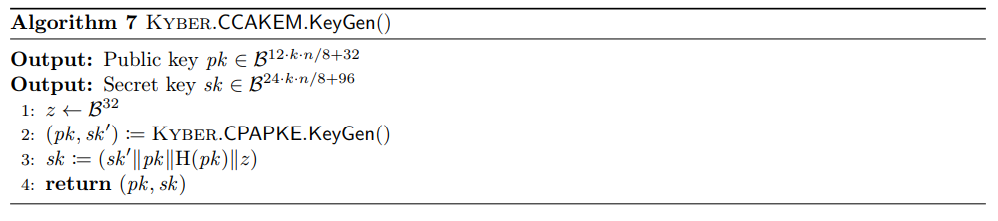

... utiliza-se diretamente o método *KeyGen* da classe *KYBER_CPAPKE*,
dado que segue o mesmo algoritmo. Tal como se visualiza na imagem em cima.

#### Método 'Enc'

Relativamente ao **algoritmo 8**:
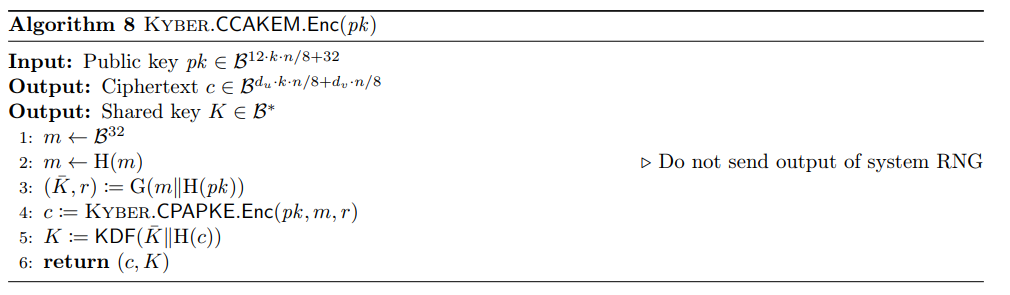

O método *Enc(pk)* é utilizado para encapsular uma 
**chave secreta** utilizando a **chave pública** *pk*.
Este método gera um *nonce* aleatório *m*, calcula uma *hash key* 
da serialização de *m* utilizando a função *H*, 
e cifra *m* utilizando a função *Enc* da classe *KYBER_CPAPKE*.
A função Enc recebe como *input* a chave pública *pk*, 
o vetor *m* e um vetor aleatório *r*, relativo às *coins*.

O nonce está a ser criado aleatoriamente usando a função *choice* 
do módulo *random*. 
A função choice([0, 1]) escolhe aleatoriamente um dos dois valores 
possíveis (0 ou 1), e esta escolha é repetida **n** vezes para
criar um vetor aleatório de *n bits*. 
Em seguida, este vetor é usado como *input* 
para o anel *Rq*, que codifica o vetor como um polinômio de grau **n-1**
com coeficientes inteiros módulo *q*. 
O polinômio resultante é, então, usado como o *nonce*
para criar a chave secreta.

#### Método 'Dec'

Por fim, o **algoritmo 9**:
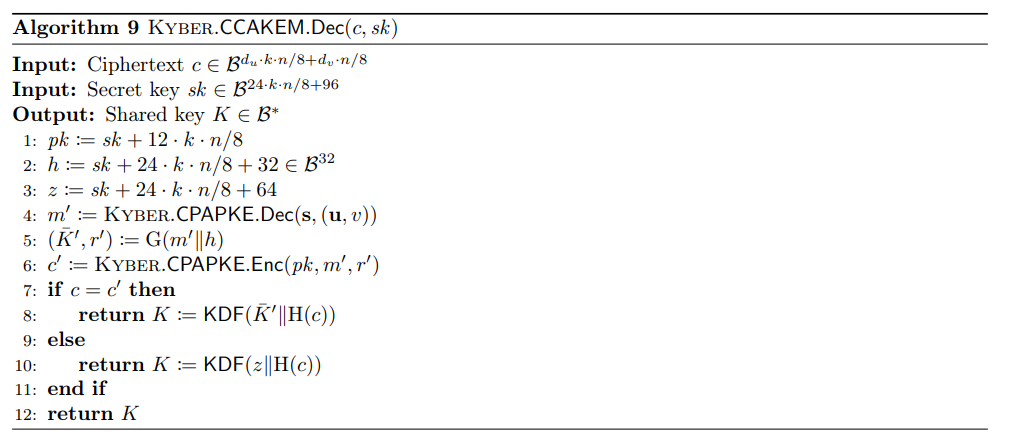

O método *Dec(c, sk)* é utilizado para 
desencapsular a **chave secreta** utilizando a 
**chave privada** *sk*. Este método decifra o vetor *m* 
cifrado no passo anterior utilizando a função *Dec* da classe 
*KYBER_CPAPKE*, calcula uma *hash key* da serialização de *m* 
utilizando a função *H* e retorna a *key*.

In [5]:
class KYBER_CPAKEM:
    
    #Função de inicialização das variaveis a usar nos métodos
    def __init__(self):
        self.cpa = KYBER_CPAPKE()
    
    ## ------------------------------- Métodos principais ------------------------------- ##
    
    # Retorna as chaves pública/privada a serem usadas no encapsulamento/desencapsulamento
    def KeyGen(self):
        
        pk, sk = self.cpa.KeyGen()
        return pk, sk
    
    # Método para encapsualar a chave secreta (com a chave pública)
    def Enc(self,pk):
        
        # Criar um valor aleatório (nonce)
        m = self.cpa.Rq([choice([0, 1]) for i in range(self.cpa.n)]) 
        # chave secreta
        k = self.H(dumps(m))
        
        # variável aleatória, coins
        r = os.urandom(256)
        c = self.cpa.Enc(pk,m,r)
        
        return c, k
    
    # Método para desencapsular a chave secreta (partilhada), através da chave privada
    def Dec(self,c,sk):
        
        # Mensagem decifrada
        m = self.cpa.Dec(sk,c)
        
        # Chave secreta (partilhada)
        k = self.H(dumps(m))
        
        return k
    
    ## ------------------------------- Métodos auxiliares ------------------------------- ##
    
    # Método de hash para criar a chave sereta (partilhada)
    def H(self, value):
        
        digest = hashes.Hash(hashes.SHA3_256())
        digest.update(value)
        
        return digest.finalize()

### Funções auxiliares (matrizes)

Todas as funções presentes na seguinte célula
são utilizadas para executar operações entre vetores
e matrizes, como **soma**, **subtração** e **multiplicação**.

- As funções *sum_vecs*, *sub_vecs* e *mult_vecs* são utilizadas 
para realizar operações elemento a elemento entre vetores, nomeadamente
a **soma**, **subtração** e **multiplicação**.

- As funções *sum_matrix*, *sub_matrix* e mult_matrix são utilizadas para 
realizar operações elemento a elemento entre matrizes, 
de modo análogo ao primeiro ponto.

- A função *m_matrix_vec* é utilizada para multiplicar uma matriz 
por um vetor e retornar o vetor resultante.

In [6]:
## Métodos auxiliares (para executar operações entre matrizes)

## -------------------------------------------- Entre vetores -------------------------------------------- ##

def sum_vecs(ff1, ff2,n):

    res = []

    for i in range(n):
        res.append((ff1[i] + ff2[i]))

    return res

def mult_vecs(ff1, ff2,n):

    res = []

    for i in range(n):
        res.append((ff1[i] * ff2[i]))

    return res

def sub_vecs(ff1, ff2,n):

    res = []

    for i in range(n):
        res.append((ff1[i] - ff2[i]))

    return res

## -------------------------------------------- Entre matrizes -------------------------------------------- ##

def sum_matrix(e1,e2,n) :

    for i in range(len(e1)):
        e1[i] = sum_vecs(e1[i], e2[i],n)

    return e1

def sub_matrix(e1,e2,n) :

    for i in range(len(e1)):
        e1[i] = sub_vecs(e1[i], e2[i],n)

    return e1

def mult_matrix(vec1, vec2, n):

    for i in range(len(vec1)):
        vec1[i] = mult_vecs(vec1[i], vec2[i],n)

    tmp = [0] * n
    for i in range(len(vec1)):
        tmp = sum_vecs(tmp, vec1[i],n)

    return tmp


# Multiplicação entre matriz e vetor
def m_matrix_vec(M,v,k,n) :
    for i in range(len(M)):
        for j in range(len(M[i])):
            M[i][j] = mult_vecs(M[i][j], v[j],n)

    tmp = [[0] * n] * k 
    for i in range(len(M)):
        for j in range(len(M[i])):
            tmp[i] = sum_vecs(tmp[i], M[i][j],n)

    return tmp

## Teste do algoritmo PKE (IND-CCA)

In [7]:
PKE = KYBER_CCAPKE()

pk, sk = PKE.KeyGen()

print("Chaves pública/privada criadas.")
print()

mens = "12345678910"
print("A mensagem a enviar: ", mens)
print()

print("A cifrar mensagem...")
print()

(y, c) = PKE.Enc(mens.encode(), pk)

print("O valor 'y': ")
print()
print(y)
print()
print("O valor 'c' (criptograma): ")
print()
print(c)
print()


print("A testar correção da decifragem...")
print()
decifra = PKE.Dec(y, c, sk)

if decifra == None:
    raise ValueError("Ocorreu um erro no processo do PKE IND-CCA!")
    
print("O processo de cifra/decifra ocorreu com sucesso!", decifra.decode())

Chaves pública/privada criadas.

A mensagem a enviar:  12345678910

A cifrar mensagem...

O valor 'y': 

b'i\xfah6\x13O\xe6\xd6\xdfV\xa3'

O valor 'c' (criptograma): 

([799*w^255 + 2*w^254 + 86*w^253 + 752*w^252 + 975*w^251 + 573*w^250 + 902*w^249 + 131*w^248 + 322*w^247 + 303*w^246 + 1017*w^245 + 618*w^244 + 124*w^243 + 534*w^242 + 476*w^241 + 670*w^240 + 1003*w^239 + 916*w^238 + 502*w^237 + 242*w^236 + 162*w^235 + 761*w^234 + 1013*w^233 + 119*w^232 + 500*w^231 + 727*w^230 + 334*w^229 + 718*w^228 + 931*w^227 + 882*w^226 + 401*w^225 + 722*w^224 + 193*w^223 + 292*w^222 + 230*w^221 + 307*w^220 + 732*w^219 + 652*w^218 + 951*w^217 + 205*w^216 + 483*w^215 + 758*w^214 + 831*w^213 + 290*w^212 + 131*w^211 + 938*w^210 + 481*w^209 + 518*w^208 + 294*w^207 + 728*w^206 + 40*w^205 + 948*w^204 + 790*w^203 + 955*w^202 + 135*w^201 + 621*w^200 + 137*w^199 + 272*w^198 + 830*w^197 + 927*w^196 + 718*w^195 + 624*w^194 + 500*w^193 + 22*w^192 + 95*w^191 + 412*w^190 + 29*w^189 + 42*w^188 + 355*w^187 + 782*w^1

## Teste do algoritmo KEM (IND-CPA)

In [8]:
KEM = KYBER_CPAKEM()

pk, sk = KEM.KeyGen()

print("Criando e encapsulando chave secreta...")
print()

c, k = KEM.Enc(pk)

print("Criptograma: ")
print()
print(c)
print()

print("Chave secreta (partilhada/encapsulada): ")
print()
print(k)
print()

print("A desencapsular a chave secreta...")
print()

shared_k = KEM.Dec(c, sk)
print("A chave partilhada é: ")
print()
print(shared_k)
print()

if k != shared_k:
    raise ValueError("Ocorreu um erro! A chave não foi desencapsulada com sucesso!", share_k)
    
print("A chave foi transmitida com sucesso!")

Criando e encapsulando chave secreta...

Criptograma: 

([302*w^255 + 231*w^254 + 454*w^253 + 355*w^252 + 765*w^251 + 339*w^250 + 759*w^249 + 848*w^248 + 654*w^247 + 131*w^246 + 999*w^245 + 254*w^244 + 199*w^243 + 59*w^242 + 428*w^241 + 422*w^240 + 608*w^239 + 189*w^238 + 515*w^237 + 872*w^236 + 24*w^235 + 796*w^234 + 633*w^233 + 445*w^232 + 701*w^231 + 657*w^230 + 241*w^229 + 624*w^228 + 777*w^227 + 980*w^226 + 361*w^225 + 33*w^224 + 516*w^223 + 961*w^222 + 791*w^221 + 826*w^220 + 610*w^219 + 973*w^218 + 202*w^217 + 209*w^216 + 445*w^215 + 875*w^214 + 970*w^213 + 5*w^212 + 741*w^211 + 172*w^210 + 1021*w^209 + 278*w^208 + 385*w^207 + 430*w^206 + 476*w^205 + 589*w^204 + 115*w^203 + 834*w^202 + 469*w^201 + 600*w^200 + 127*w^199 + 693*w^198 + 228*w^197 + 522*w^196 + 756*w^195 + 891*w^194 + 156*w^193 + 512*w^192 + 527*w^191 + 374*w^190 + 252*w^189 + 540*w^188 + 566*w^187 + 226*w^186 + 569*w^185 + 846*w^184 + 242*w^183 + 887*w^182 + 286*w^180 + 789*w^179 + 355*w^178 + 227*w^177 + 931*w^176 